In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="your_api_key")
project = rf.workspace("daouda-projects").project("license-plate-recognition-rxg4e-yfkvw")
version = project.version(1)
dataset = version.download("yolov8")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.9/86.9 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 88.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 103.2 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to plate-recognition-1 in yolov8:: 100%|██████████| 20262/20262 [00:06<00:00, 3015.55it/s]


In [ ]:
# 📌 Section 1 : Installations et Imports
!pip install roboflow ultralytics opencv-python matplotlib seaborn --quiet

import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from roboflow import Roboflow
from collections import Counter

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 86.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 892.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 91.0 MB/s eta 0:00:00


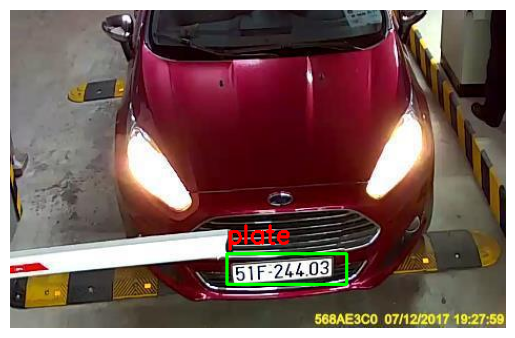

In [ ]:
# 📌 Section 3 : Affichage d'une image avec bounding box

def draw_bbox(image_path, label_path, class_names=["plate"]):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w, _ = image.shape

    with open(label_path, "r") as f:
        lines = f.readlines()

    for line in lines:
        cls_id, x_center, y_center, bw, bh = map(float, line.strip().split())
        x_center *= w
        y_center *= h
        bw *= w
        bh *= h

        x1 = int(x_center - bw / 2)
        y1 = int(y_center - bh / 2)
        x2 = int(x_center + bw / 2)
        y2 = int(y_center + bh / 2)

        cv2.rectangle(image, (x1, y1), (x2, y2), (0,255,0), 2)
        cv2.putText(image, class_names[int(cls_id)], (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,0,0), 2)

    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Affichage aléatoire d'une image
img_dir = os.path.join(dataset.location, "train/images")
label_dir = os.path.join(dataset.location, "train/labels")

sample_img = random.choice(os.listdir(img_dir))
draw_bbox(os.path.join(img_dir, sample_img),
          os.path.join(label_dir, sample_img.replace(".jpg", ".txt").replace(".png", ".txt")))


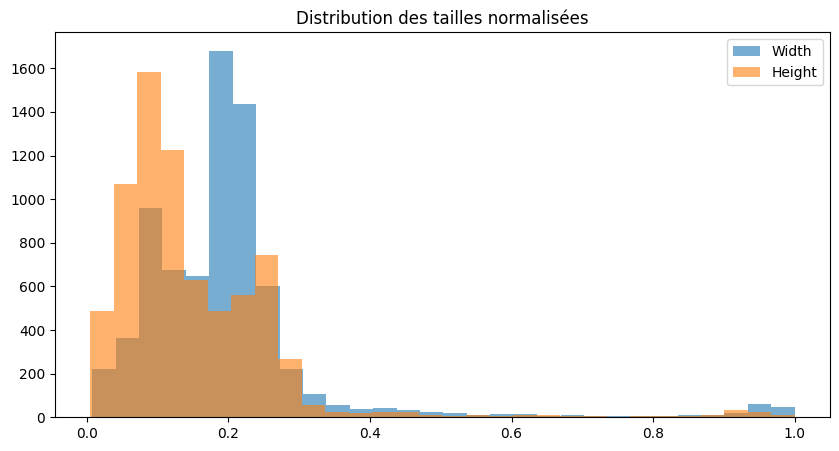

In [ ]:
# 📌 Section 4 : Statistiques sur les bounding boxes
bbox_widths, bbox_heights, aspect_ratios, centers_x, centers_y = [], [], [], [], []

for label_file in os.listdir(label_dir):
    with open(os.path.join(label_dir, label_file)) as f:
        lines = f.readlines()
        for line in lines:
            _, x, y, w, h = map(float, line.strip().split())
            bbox_widths.append(w)
            bbox_heights.append(h)
            centers_x.append(x)
            centers_y.append(y)
            aspect_ratios.append(w / h)

# Distribution largeur et hauteur
plt.figure(figsize=(10,5))
plt.hist(bbox_widths, bins=30, alpha=0.6, label='Width')
plt.hist(bbox_heights, bins=30, alpha=0.6, label='Height')
plt.title("Distribution des tailles normalisées")
plt.legend()
plt.show()


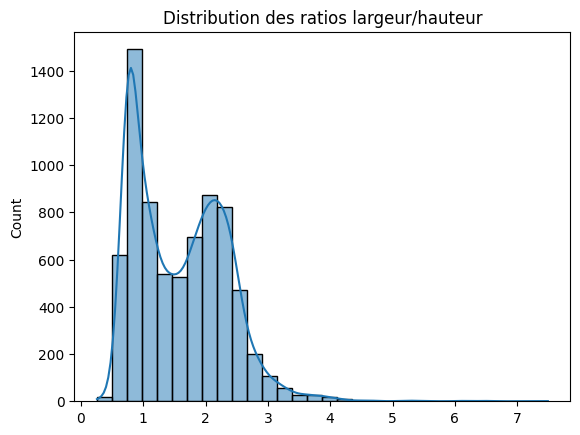

In [ ]:
# 📌 Section 5 : Distribution des ratios largeur / hauteur
sns.histplot(aspect_ratios, kde=True, bins=30)
plt.title("Distribution des ratios largeur/hauteur")
plt.show()


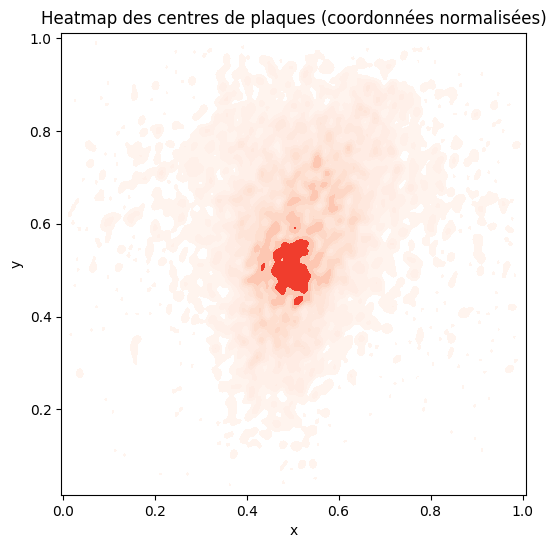

In [ ]:
# 📌 Section 6 : Heatmap des centres
plt.figure(figsize=(6,6))
sns.kdeplot(x=centers_x, y=centers_y, cmap="Reds", fill=True, bw_adjust=0.2)
plt.title("Heatmap des centres de plaques (coordonnées normalisées)")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

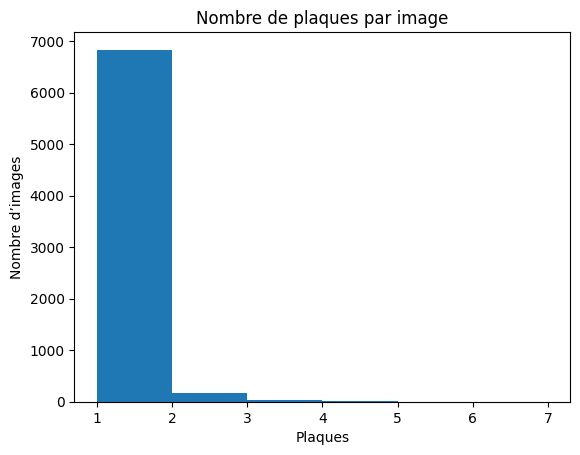

In [ ]:
# 📌 Section 7 : Nombre de plaques par image
n_labels = []
for file in os.listdir(label_dir):
    with open(os.path.join(label_dir, file)) as f:
        n_labels.append(len(f.readlines()))

plt.hist(n_labels, bins=range(1, max(n_labels)+2))
plt.title("Nombre de plaques par image")
plt.xlabel("Plaques")
plt.ylabel("Nombre d’images")
plt.show()

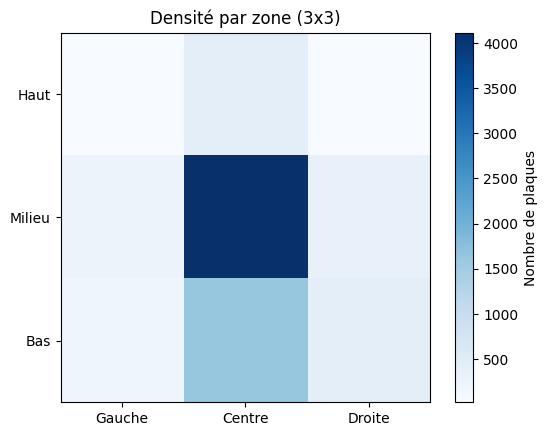

In [ ]:
# 📌 Section 8 : Carte 3x3 des zones de présence
zones = np.zeros((3, 3))

for x, y in zip(centers_x, centers_y):
    row = int(y * 3)
    col = int(x * 3)
    row = min(row, 2)
    col = min(col, 2)
    zones[row, col] += 1

plt.imshow(zones, cmap='Blues')
plt.title("Densité par zone (3x3)")
plt.xticks([0, 1, 2], ['Gauche', 'Centre', 'Droite'])
plt.yticks([0, 1, 2], ['Haut', 'Milieu', 'Bas'])
plt.colorbar(label="Nombre de plaques")
plt.show()

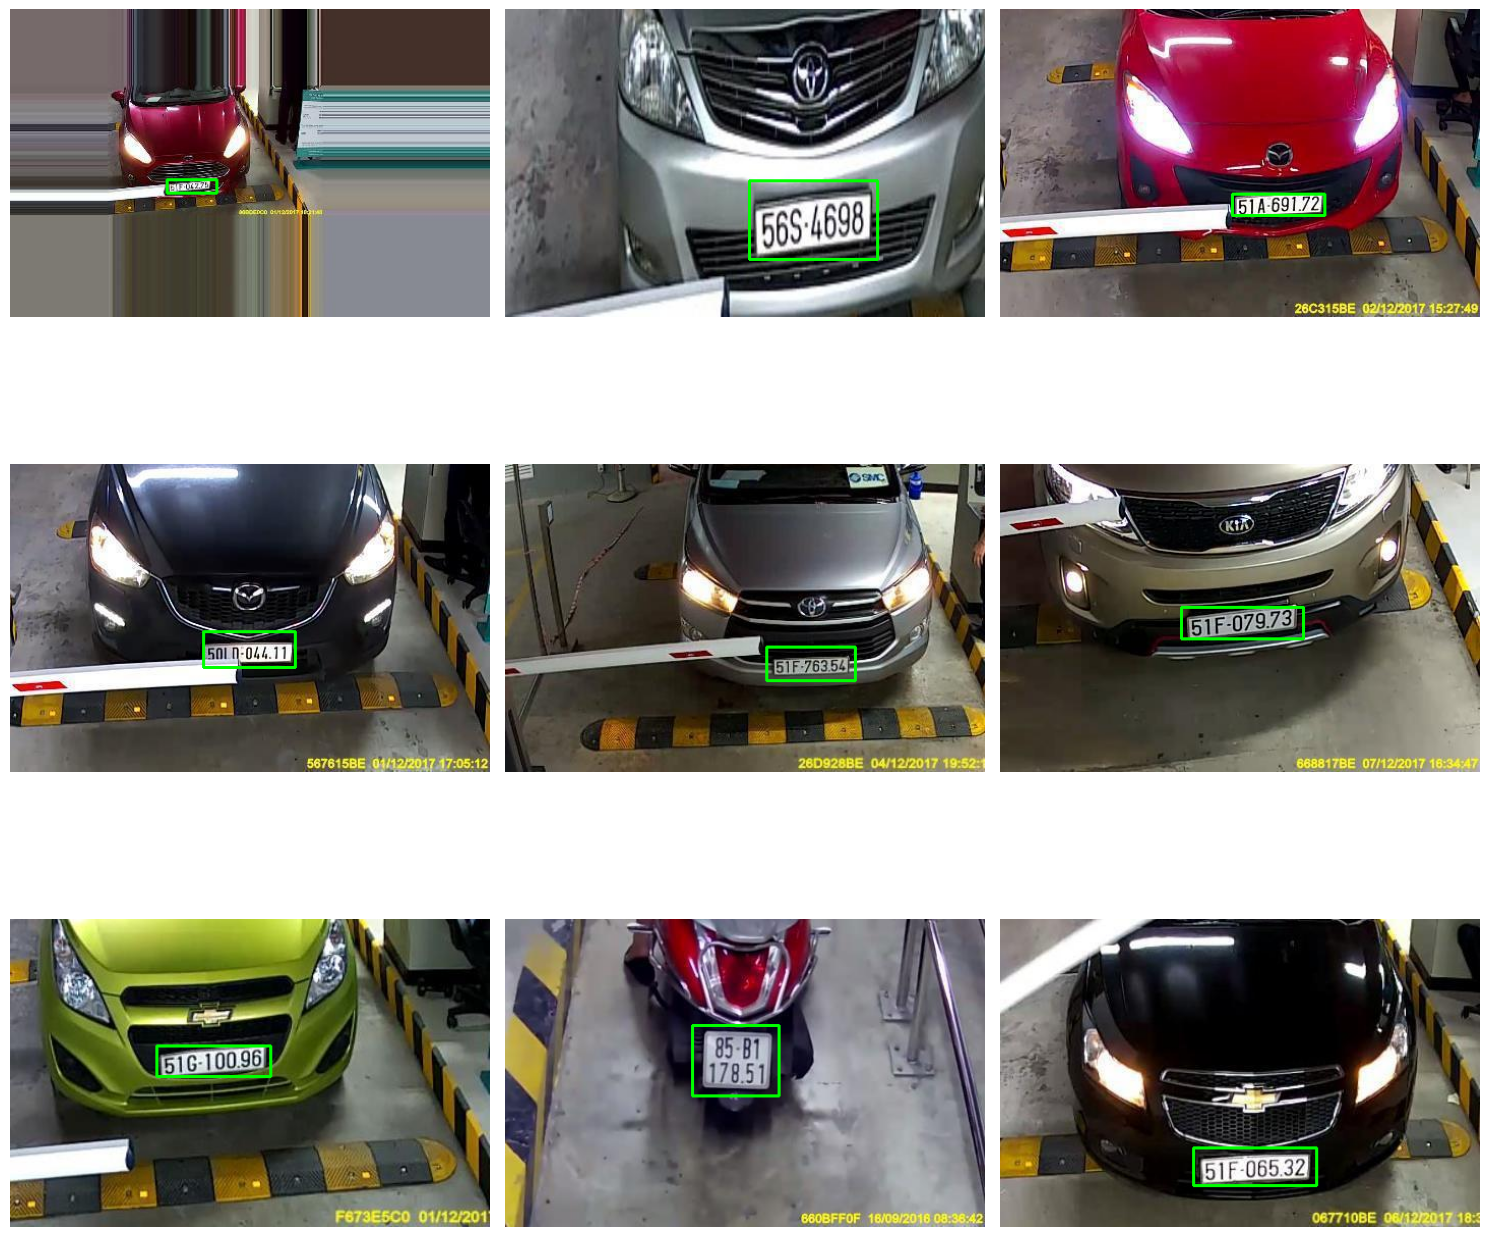

In [ ]:
# 📌 Section 9 : Mosaic de 9 images annotées

fig, axes = plt.subplots(3, 3, figsize=(15,15))
sample_imgs = random.sample(os.listdir(img_dir), 9)

for ax, img_name in zip(axes.flatten(), sample_imgs):
    img_path = os.path.join(img_dir, img_name)
    lbl_path = os.path.join(label_dir, img_name.replace(".jpg", ".txt").replace(".png", ".txt"))

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, _ = img.shape

    with open(lbl_path, "r") as f:
        for line in f:
            cls_id, x_center, y_center, bw, bh = map(float, line.strip().split())
            x_center *= w
            y_center *= h
            bw *= w
            bh *= h

            x1 = int(x_center - bw / 2)
            y1 = int(y_center - bh / 2)
            x2 = int(x_center + bw / 2)
            y2 = int(y_center + bh / 2)
            cv2.rectangle(img, (x1, y1), (x2, y2), (0,255,0), 2)

    ax.imshow(img)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving results.csv to results.csv


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Charger le fichier
df = pd.read_csv("results.csv")

# Convertir la colonne 'epoch' en entier
df['epoch'] = df['epoch'].astype(int)

# Appliquer un style esthétique
sns.set(style="whitegrid", font_scale=1.2)

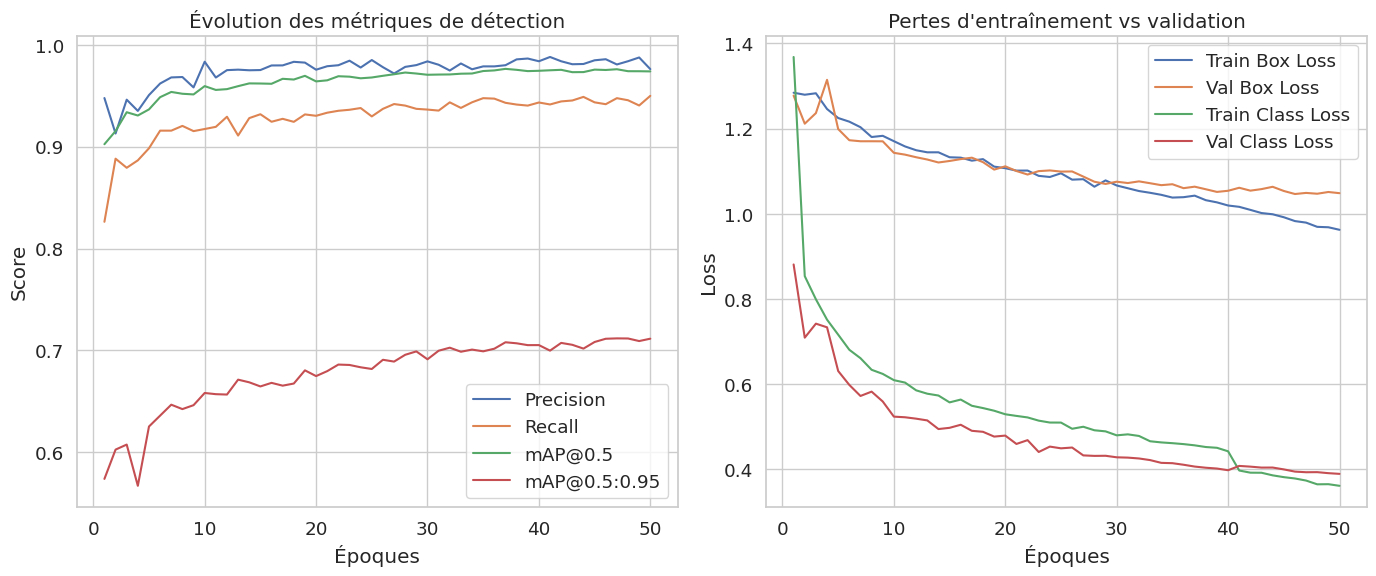

In [ ]:
plt.figure(figsize=(14, 6))
sns.set_style("whitegrid")

# 1. Courbes des métriques
plt.subplot(1, 2, 1)
sns.lineplot(data=df, x="epoch", y="metrics/precision(B)", label="Precision")
sns.lineplot(data=df, x="epoch", y="metrics/recall(B)", label="Recall")
sns.lineplot(data=df, x="epoch", y="metrics/mAP50(B)", label="mAP@0.5")
sns.lineplot(data=df, x="epoch", y="metrics/mAP50-95(B)", label="mAP@0.5:0.95")
plt.title("Évolution des métriques de détection")
plt.xlabel("Époques")
plt.ylabel("Score")
plt.legend()

# 2. Courbes des pertes (train & val)
plt.subplot(1, 2, 2)
sns.lineplot(data=df, x="epoch", y="train/box_loss", label="Train Box Loss")
sns.lineplot(data=df, x="epoch", y="val/box_loss", label="Val Box Loss")
sns.lineplot(data=df, x="epoch", y="train/cls_loss", label="Train Class Loss")
sns.lineplot(data=df, x="epoch", y="val/cls_loss", label="Val Class Loss")
plt.title("Pertes d'entraînement vs validation")
plt.xlabel("Époques")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

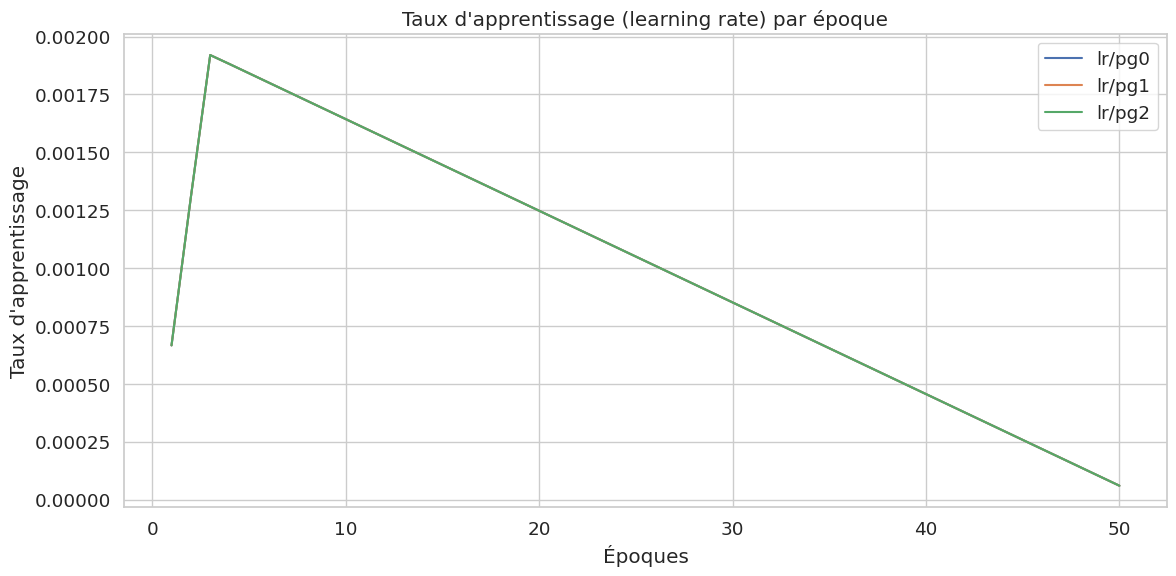

In [ ]:
# 4. Taux d'apprentissage au cours de l'entraînement
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x="epoch", y="lr/pg0", label="lr/pg0")
sns.lineplot(data=df, x="epoch", y="lr/pg1", label="lr/pg1")
sns.lineplot(data=df, x="epoch", y="lr/pg2", label="lr/pg2")
plt.title("Taux d'apprentissage (learning rate) par époque")
plt.xlabel("Époques")
plt.ylabel("Taux d'apprentissage")
plt.legend()
plt.tight_layout()
plt.show()

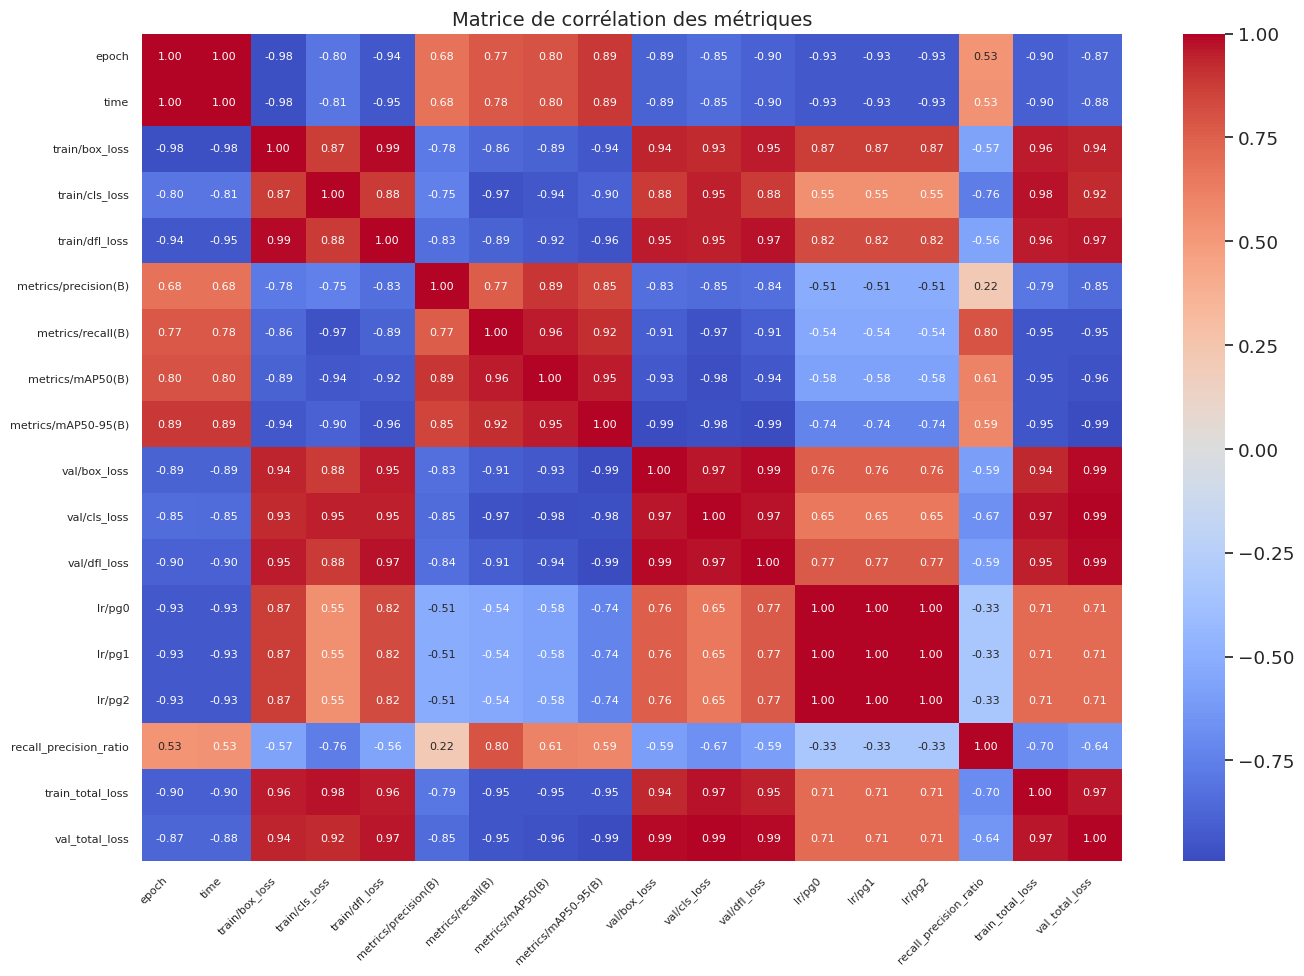

In [ ]:
plt.figure(figsize=(14, 10))
corr = df.corr(numeric_only=True)

sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=False,
    annot_kws={"size": 8}  # taille du texte à l'intérieur des cases
)

plt.title("Matrice de corrélation des métriques", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.show()